# 10X ``tcellmatch`` Tutorial - Training

Make sure to run the previous notebook 10x_dataset_preprocessing.ipynb before running this notebook. It also contains details on the dataset used in this tutorial and how it is processed.

In [1]:
# Third party libraries
import pandas as pd
import torch
import numpy as np  
import wandb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from datetime import datetime
import os

# Custom/local 
import tcellmatch.api as tm

# ML models
from sklearn.metrics import confusion_matrix

In [2]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

# Load Data

This data is saved when running the previous notebook ``10x_dataset_preprocessing.ipynb.``

In [3]:
ffn = tm.models.EstimatorFfn()
indir = '../tutorial_data/'
data = np.load(f"{indir}ffn_data_big_c.npz")
ffn.x_train = data["x_train"]
ffn.covariates_train = data["covariates_train"]
ffn.y_train = data["y_train"]
ffn.x_test = data["x_test"]
ffn.covariates_test = data["covariates_test"]
ffn.y_test = data["y_test"]
ffn.clone_train = data["clone_train"]

These indices are used to split the data into train, validation, and test sets.

In [4]:
ffn.load_idx(f'{indir}SAVED_IDX')

# Build Model
Here, we can build two models: a BiLSTM-based or self-attention-based model, detailed above.

Loss has the following possible parameters

1. Discrete
    1. Binary Crossentropy (param "bce")
    2. Weighted Binary Crossentropy (param "wbce")
    3. Categorical Crossentropy (param "cce")
2. Continuous
    1. MMD (param "mmd")
    2. Mean Squared error (param "mse")
    3. Poisson (param "pois")
    
Calling one of these creates the model and sets the ffn.model attribute.

In [5]:
model_name = 'bilstm'
USE_BIND_COUNTS = True
LR = 0.005
depth_final_dense = 3

In [6]:
if model_name.lower() == 'self-attention':
    # n_layers = 5
    # ffn.build_self_attention(
    #     aa_embedding_dim=0,
    #     attention_size=[5] * n_layers, # hidden size of each attention layer
    #     attention_heads=[4] * n_layers, # number of heads at each layer
    #     optimizer='adam',
    #     lr=0.001,
    #     loss='pois' if USE_BIND_COUNTS else 'wbce',
    #     label_smoothing=0
    # )
    # replicating Alan's code below...
    attention_size = [128, 128]
    attention_heads = [16, 16]
    params = {"attention_size" : attention_size,
              "attention_heads" : attention_heads}
    ffn.build_self_attention(
        residual_connection=True,
        aa_embedding_dim=26,
        # hidden size of each attention layer
        attention_size=attention_size,
        # number of heads at each layer
        use_covariates=False,
        attention_heads=attention_heads,
        depth_final_dense=3,
        optimizer='adam',
        lr=LR,
        loss='pois' if USE_BIND_COUNTS else 'wbce',
        label_smoothing=0
    )

elif model_name.lower() == 'bilstm':
    # ffn.build_bilstm(
    #     topology = [10, 10, 10, 10], # The depth of each bilstm layer (length of feature vector)
    #     # Dimension of the linear amino acid embedding, ie number of 1x1 convolutional filters.
    #     # set to input dimension if aa_embedding_dim==0.
    #     aa_embedding_dim=0,
    #     optimizer='adam',
    #     lr=0.001,
    #     loss='pois' if USE_BIND_COUNTS else 'wcbe',
    #     label_smoothing=0,
    #     use_covariates=False,        # whether to assume covariates in model architecture
    #     one_hot_y=not USE_BIND_COUNTS # whether we are predicting max binding categorical or bind counts
    # )
    topology = [32, 32, 32]#[128, 128, 128, 128]
    params = {"topology" : topology}
    ffn.build_bilstm(
        # The depth of each bilstm layer (length of feature vector)
        topology = topology,
        # Dimension of the linear amino acid embedding, ie number of 1x1 convolutional filters.
        # set to input dimension if aa_embedding_dim==0.
        aa_embedding_dim=0,
        # depth_final_dense=depth_final_dense,
        optimizer='adam',
        lr=LR,
        loss='pois' if USE_BIND_COUNTS else 'wcbe',
        label_smoothing=0,
        depth_final_dense=depth_final_dense,
        # whether to assume covariates in model architecture
        use_covariates=False,
        # whether we are predicting max binding categorical
        # or binding counts
        one_hot_y=not USE_BIND_COUNTS
    )

elif model_name.lower() == 'bigru':
    ffn.build_bigru(
        topology=[10, 10, 10],
        aa_embedding_dim=0,
        lr=0.005,
        loss='pois' if USE_BIND_COUNTS else 'wbce',
        optimize_for_gpu= True,
    )
elif model_name.lower() == 'cnn':
    ffn.build_conv(
        n_conv_layers = 3,
        depth_final_dense = 3,
        filter_widths = [3, 5, 3],  # Filter widths for the three convolutional layers
        filters = [16, 32, 64],  # Output channels for the three convolutional layers
        pool_sizes = [2] * 3,  # Size of the pooling window
        pool_strides = [2] * 3,  # Stride for moving the pooling window,
        loss='pois' if USE_BIND_COUNTS else 'wbce',
    )
ffn.model = ffn.model.to(device) 

for param in ffn.model.parameters():
    param = param.to(device) 

0 3
1 3
2 3


# Train model
Train this model for 2 epochs     

In [7]:
ffn.idx_train.shape

(0,)

In [8]:
EPOCHS = 10
batch_size = 100

In [9]:
# train_curve, val_curve = ffn.train(
train_curve, val_curve, antigen_loss, antigen_loss_val = ffn.train(
    epochs=EPOCHS,
    batch_size=batch_size,
    allow_early_stopping=False,
    print_loss=True,
    lr_schedule_factor=0.99999,
    use_wandb=False,
    patience=8
    )

started training...
Number of observations in evaluation data: 7875
Number of observations in training data: 71121
Epoch 0, loss: 1.33
Epoch 1, loss: 1.18
Epoch 2, loss: 1.15
Epoch 3, loss: 1.1
Epoch 4, loss: 1.05
Epoch 5, loss: 1.13
Epoch 6, loss: 1.14
Epoch 7, loss: 1.1
Epoch 8, loss: 1.06
Epoch 9, loss: 1.04


# Plot Loss Curves

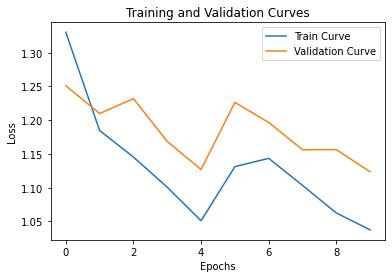

In [10]:
# Plotting the curves
plt.plot(train_curve, label='Train Curve')
plt.plot(val_curve, label='Validation Curve')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Curves')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

## Get Embeddings

In [11]:
ffn.model.get_embeddings(torch.ones(1, 1, 40, 26, device=device))

tensor([[-2.2827e-05, -1.9694e-04, -9.4626e-03,  3.8275e-04, -2.4889e-02,
         -3.1754e-03,  2.2196e-03, -2.9990e-03, -7.7215e-04, -1.3259e-03,
          3.2345e-04,  3.6104e-04, -1.3456e-03, -1.3535e-02, -1.8009e-04,
         -4.1558e-03, -1.2060e-02,  1.9685e-01,  8.0747e-03,  8.3264e-03,
         -1.6051e-03, -7.6313e-03,  1.0483e-03,  5.1939e-03,  2.9148e-04,
          4.9226e-04, -3.4558e-03,  3.6088e-03, -2.9402e-04, -6.6177e-04,
         -1.9010e-04, -5.9674e-03, -2.6040e-03, -6.6343e-04, -3.5214e-03,
         -9.1086e-04, -4.5456e-04,  2.2633e-04, -1.6297e-03,  6.6495e-04,
         -5.3482e-03, -9.4274e-04,  1.8604e-03,  1.2868e-03,  4.4046e-04,
         -2.0486e-03,  4.9938e-04, -2.6695e-03,  1.7165e-01, -8.0617e-04,
         -7.2405e-04,  3.4855e-04,  1.7937e-03, -8.6251e-05,  1.3402e-01,
          1.8611e-05, -1.2693e-01, -7.9927e-04, -1.3779e-01, -4.3448e-04,
         -1.0604e-03,  2.2929e-03,  3.5351e-04, -6.8068e-04]], device='cuda:0',
       grad_fn=<SliceBackward0>)

# Use Model

## Evaluate on test set
This evaluates the data and returns binary and custom (i.e., based on how the model was built above) loss metrics

In [12]:
ffn.evaluate(
    # given k, returns loss only over the kth antigen in test
    antigen_col=None
)

{'test': {PoissonNLLLoss(): 1.1272752406881519,
  'Binary Accuracy': 43.97527564316739}}

## Save the Model

In [13]:
timestamp = datetime.now().strftime("%-m-%-d--%-H:%M")
os.makedirs(f'{indir}saved_model-{timestamp}', exist_ok=True)
# save_yhat means save predictions
ffn.save_model_full(f'{indir}saved_model-{timestamp}', save_yhat=True, save_train_data=False)
print(f'Saved model to {indir}saved_model-{timestamp}')

Saved model to ../tutorial_data/saved_model-8-15--23:18


In [14]:
timestamp

'8-15--23:18'

## Evaluate/Compare the Model
We predict the labels on test data and store to ``ffn.predictions``

In [15]:
ffn.predict()
ffn.predictions.shape

(8979, 50)

## Create Confusion Matrix
This is only applicable, of course, if you've used the one-hot encoded maximum binding y-data. If it is, you can use this to also compare with the original tcellmatch in torch


In [16]:
if not USE_BIND_COUNTS:
    true_labels = np.argmax(ffn.y_test, axis=1)
    predicted_labels = np.argmax(ffn.predictions, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## Reproduce evaluation in a new instance of model w/ same weights
We load the model, with weights and data included, and evaluate and predict on the test data

In [17]:
ffn2 = tm.models.EstimatorFfn()
ffn2.load_model_full(fn=f'{indir}saved_model-{timestamp}', load_train_data=False)
ffn2.model = ffn2.model.to(device)

0 3
1 3
2 3


In [18]:
# TODO -> fix this
# ffn2.model.embed_attention_layers = torch.nn.ModuleList([l.to(device=device) for l in ffn2.model.embed_attention_layers])
# ffn2.model.linear_layers = torch.nn.ModuleList([l.to(device=device) for l in ffn2.model.linear_layers])

In [19]:
print(ffn2.evaluate(test_only=True))
ffn2.predict()

{'test': {PoissonNLLLoss(): 1.1272752406881519, 'Binary Accuracy': 43.97527564316739}}


## Compare with trivial prediction

In [20]:
ffn.predict()

In [21]:
p_lmd = torch.nn.PoissonNLLLoss(full=True, reduction='none')

log_p_yhat = -p_lmd(torch.Tensor(ffn.predictions), torch.Tensor(ffn.y_test))
trivial_pred = ffn.y_test.mean(axis=0)
trivial_pred_vec = trivial_pred.copy()
# repeat trivial prediction for each of the n datapoints
trivial_pred = np.repeat(trivial_pred[np.newaxis, :], log_p_yhat.shape[0], axis=0)
trivial_log_p = -p_lmd(torch.Tensor(trivial_pred), torch.Tensor(ffn.y_test))

In [22]:
# ffn.x_train[ffn.idx_test]

In [23]:
log_p_yhat = log_p_yhat.mean(0)

In [24]:
trivial_log_p = trivial_log_p.mean(0)

(-0.5, 49.5)

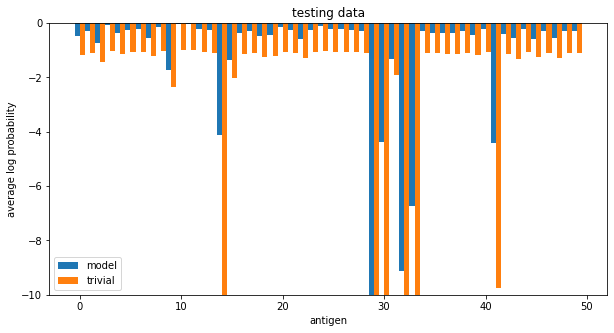

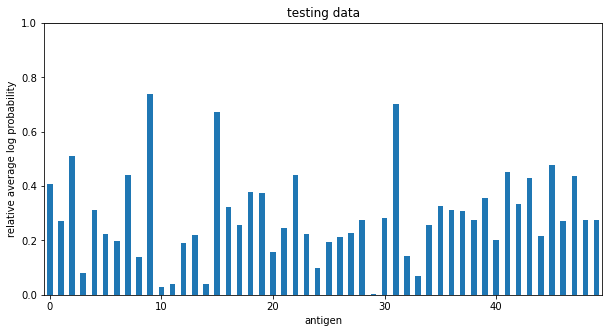

In [25]:
fig, ax = plt.subplots(figsize=[10, 5])
plt.title("testing data")
ax.bar(np.arange(len(log_p_yhat))-0.25, log_p_yhat, width=0.5, label='model')
ax.bar(np.arange(len(trivial_log_p))+0.25, trivial_log_p, width=0.5, label='trivial')
plt.ylim(-10, 0)
plt.ylabel("average log probability")
plt.xlabel("antigen")
ax.legend()

# wandb.log({"test antigen liks to trivial": wandb.Image(plt)})

fig, ax = plt.subplots(figsize=[10, 5])
plt.title("testing data")
plt.plot([-10, len(log_p_yhat)+10], [1, 1], color='grey')
ax.bar(np.arange(len(log_p_yhat)), log_p_yhat / trivial_log_p, width=0.5)
plt.ylabel("relative average log probability")
plt.xlabel("antigen")
plt.ylim(0, 1)
plt.xlim(-0.5, len(log_p_yhat)-0.5)

## Plot actual vs. predicted counts

In [26]:
ffn.predict()

Line of best fit slope:  0.27071042356284175


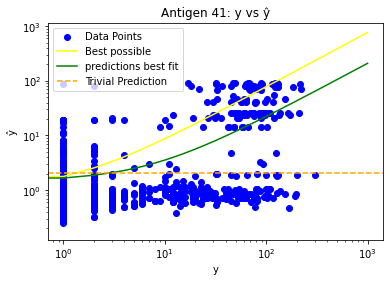

In [27]:
# Create a scatter plot
antigen = 41
plt.scatter(ffn.y_test[:, antigen], np.exp(ffn.predictions[:, antigen]), label='Data Points', color='blue')

# Plot the equation x = y
line = np.linspace(1, np.max(ffn.y_test), num=1000)
slope, intercept = np.polyfit(ffn.y_test[:, antigen],  np.exp(ffn.predictions[:, antigen]), deg=1)
line_of_best_fit = slope * line + intercept
plt.plot(line, label='Best possible', color='yellow')
plt.plot(line_of_best_fit, label='predictions best fit', color='green')
plt.axhline(y=trivial_pred_vec[antigen], color='orange', linestyle='--', label='Trivial Prediction')
print('Line of best fit slope: ', slope)
# Set labels and title
plt.xlabel('y')
plt.ylabel('ŷ')
plt.title(f'Antigen {antigen}: y vs ŷ')
# plt.ylim(0, 25)  # Change the range according to your preference
# plt.xlim(0, 25)  # Change the range according to your preference
plt.xscale('log')    # Set x-axis to logarithmic scale
plt.yscale('log')    # Set y-axis to logarithmic scale
# Add a legend
plt.legend()
plt.show()

## Plot Residuals
This function outputs a MatPlotLib histogram of the residuals of the given antigen index (here 0) over the test data. predict() must be called first to generate our test predictions.

In [28]:
# %% [collapsed] Import list of target binders and non-binders
target_ids = [
    'A0101_VTEHDTLLY_IE-1_CMV',
    'A0201_KTWGQYWQV_gp100_Cancer',
    'A0201_ELAGIGILTV_MART-1_Cancer',
    'A0201_CLLWSFQTSA_Tyrosinase_Cancer',
    'A0201_IMDQVPFSV_gp100_Cancer',
    'A0201_SLLMWITQV_NY-ESO-1_Cancer',
    'A0201_KVAELVHFL_MAGE-A3_Cancer',
    'A0201_KVLEYVIKV_MAGE-A1_Cancer',
    'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase',
    'A0201_LLDFVRFMGV_EBNA-3B_EBV',
    'A0201_LLMGTLGIVC_HPV-16E7_82-91',
    'A0201_CLGGLLTMV_LMP-2A_EBV',
    'A0201_YLLEMLWRL_LMP1_EBV',
    'A0201_FLYALALLL_LMP2A_EBV',
    'A0201_GILGFVFTL_Flu-MP_Influenza',
    'A0201_GLCTLVAML_BMLF1_EBV',
    'A0201_NLVPMVATV_pp65_CMV',
    'A0201_ILKEPVHGV_RT_HIV',
    'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2',
    'A2402_CYTWNQMNL_WT1-(235-243)236M_Y',
    'A0201_RTLNAWVKV_Gag-protein_HIV',
    'A0201_KLQCVDLHV_PSA146-154',
    'A0201_LLFGYPVYV_HTLV-1',
    'A0201_SLFNTVATL_Gag-protein_HIV',
    'A0201_SLYNTVATLY_Gag-protein_HIV',
    'A0201_SLFNTVATLY_Gag-protein_HIV',
    'A0201_RMFPNAPYL_WT-1',
    'A0201_YLNDHLEPWI_BCL-X_Cancer',
    'A0201_MLDLQPETT_16E7_HPV',
    'A0301_KLGGALQAK_IE-1_CMV',
    'A0301_RLRAEAQVK_EMNA-3A_EBV',
    'A0301_RIAAWMATY_BCL-2L1_Cancer',
    'A1101_IVTDFSVIK_EBNA-3B_EBV',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV',
    'B3501_IPSINVHHY_pp65_CMV',
    'A2402_AYAQKIFKI_IE-1_CMV',
    'A2402_QYDPVAALF_pp65_CMV',
    'B0702_QPRAPIRPI_EBNA-6_EBV',
    'B0702_TPRVTGGGAM_pp65_CMV',
    'B0702_RPPIFIRRL_EBNA-3A_EBV',
    'B0702_RPHERNGFTVL_pp65_CMV',
    'B0801_RAKFKQLL_BZLF1_EBV',
    'B0801_ELRRKMMYM_IE-1_CMV',
    'B0801_FLRGRAYGL_EBNA-3A_EBV',
    'A0101_SLEGGGLGY_NC',
    'A0101_STEGGGLAY_NC',
    'A0201_ALIAPVHAV_NC',
    'A2402_AYSSAGASI_NC',
    'B0702_GPAESAAGL_NC',
    'NR(B0801)_AAKGRGAAL_NC',
]
nc_cols = [
    'A0101_SLEGGGLGY_NC',
    'A0101_STEGGGLAY_NC',
    'A0201_ALIAPVHAV_NC',
    'A2402_AYSSAGASI_NC',
    'B0702_GPAESAAGL_NC',
    'NR(B0801)_AAKGRGAAL_NC'
]

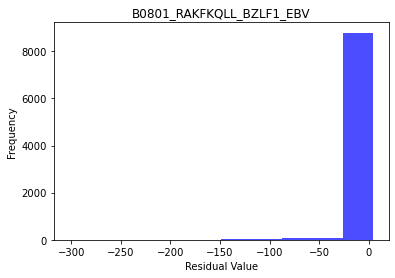

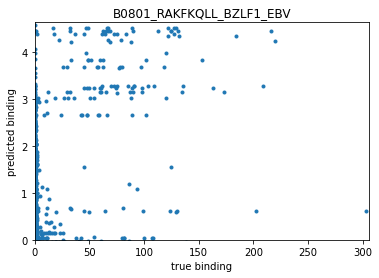

In [29]:
ffn.plot_residuals(antigen_idx=41, target_ids=target_ids)
ffn.compare_preds(antigen_idx=41, target_ids=target_ids)